In [1]:
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import re
import base64
import time
import matplotlib.pyplot as plt

In [2]:
base_search_url = "https://find-and-update.company-information.service.gov.uk/advanced-search/get-results"
params = {
    "companyNameIncludes": "",
    "companyNameExcludes": "",
    "registeredOfficeAddress": "BS16",
    "incorporationFromDay": "",
    "incorporationFromMonth": "",
    "incorporationFromYear": "",
    "incorporationToDay": "01",
    "incorporationToMonth": "01",
    "incorporationToYear": "2019",
    "status": "active",
    "sicCodes": "",
    "type": "ltd",
    "dissolvedFromDay": "",
    "dissolvedFromMonth": "",
    "dissolvedFromYear": "",
    "dissolvedToDay": "",
    "dissolvedToMonth": "",
    "dissolvedToYear": "",
    "page": 1
}

def fetch_company_numbers(soup):
    company_elements = soup.find_all('tr', class_='govuk-table__row')
    numbers = []

    for element in company_elements:
        match = re.search(r'/company/(\d{8})', str(element))
        if match:
            numbers.append(match.group(1))
    
    return numbers

company_numbers = []

# Fetching all company numbers
while True:
    response = requests.get(base_search_url, params=params)
    soup = BeautifulSoup(response.content, 'html.parser')
    company_numbers.extend(fetch_company_numbers(soup))

    next_page = soup.find('a', id='next-page')
    if not next_page:
        break
    params["page"] += 1

print("Company numbers found:", company_numbers)

Company numbers found: ['00935399', '00972282', '00981567', '01067344', '01190495', '02446988', '02574992', '03285487', '03326267', '03386085', '03422670', '03453986', '03455243', '03582586', '02069325', '01637639', '01767946', '01874133', '02090617', '03670066', '03712969', '00478127', '03196621', '03552791', '02337722', '02371246', '02378534', '02388291', '02588180', '06388989', '06414128', '06433276', '06515604', '06553625', '05190487', '05222119', '05232688', '05255265', '05258186', '05356740', '05407874', '04483144', '04501652', '04541047', '04544799', '04547227', '04554805', '04556645', '04668556', '05733074', '05746314', '05831670', '05871727', '05891401', '05516732', '05575151', '05576653', '05653563', '05656684', '05658724', '05668096', '05680411', '04690757', '04700019', '04710836', '04709613', '04746940', '04833272', '04844058', '06187167', '06382529', '06220856', '06226008', '06261898', '06337749', '06374102', '06540063', '06541790', '08071606', '08178031', '08184353', '081

In [3]:
import requests
import base64
from ratelimit import limits, sleep_and_retry

time.sleep(15)

# Function to check the number of active officers
@sleep_and_retry
@limits(calls=600, period=300)
def has_less_than_two_active_officers(company_number, headers):
    url = f"https://api.company-information.service.gov.uk/company/{company_number}/officers"
    
    # Send a GET request to the API
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch officer data for company {company_number}, Status Code: {response.status_code}")
        print(f"Response: {response.text}")
        return True  # Assume true if unable to fetch data

    # Parse the JSON content
    data = response.json()
    active_count = data.get("active_count", 0)
    
    return active_count < 2

# Base URL of the filing history API
base_url = "https://api.company-information.service.gov.uk/company"

# API key for authentication
api_key = "d45efe41-e43d-47ee-a4d0-97c0239857a2"
auth_header = base64.b64encode(f"{api_key}:".encode()).decode()

# Headers for the API requests
headers = {"Authorization": f"Basic {auth_header}"}

# Filter the company numbers
filtered_company_numbers = []
for company_number in company_numbers:
    if not has_less_than_two_active_officers(company_number, headers):
        filtered_company_numbers.append(company_number)
    else:
        print(f"Company {company_number} has less than 2 active officers. Skipping.")

print("Filtered company numbers:", filtered_company_numbers)


Company 04501652 has less than 2 active officers. Skipping.
Company 05653563 has less than 2 active officers. Skipping.
Company 05658724 has less than 2 active officers. Skipping.
Company 04710836 has less than 2 active officers. Skipping.
Company 04833272 has less than 2 active officers. Skipping.
Company 06220856 has less than 2 active officers. Skipping.
Company 06261898 has less than 2 active officers. Skipping.
Company 06541790 has less than 2 active officers. Skipping.
Company 08195882 has less than 2 active officers. Skipping.
Company 08213597 has less than 2 active officers. Skipping.
Company 08231238 has less than 2 active officers. Skipping.
Company 08229332 has less than 2 active officers. Skipping.
Company 08668036 has less than 2 active officers. Skipping.
Company 08812128 has less than 2 active officers. Skipping.
Company 08857380 has less than 2 active officers. Skipping.
Company 08859508 has less than 2 active officers. Skipping.
Company 08858698 has less than 2 active 

In [4]:
from collections import deque

class TokenBucket:
    def __init__(self, tokens, fill_rate):
        self.capacity = tokens
        self.tokens = tokens
        self.fill_rate = fill_rate
        self.timestamp = time.time()

    def consume(self):
        now = time.time()
        tokens_to_add = (now - self.timestamp) * self.fill_rate
        self.tokens = min(self.capacity, self.tokens + tokens_to_add)
        self.timestamp = now
        if self.tokens >= 1:
            self.tokens -= 1
            return 0
        else:
            return (1 - self.tokens) / self.fill_rate

def should_ignore_company(filings):
    for filing in filings:
        doc_type = filing["Type"]
        description = filing["Description"].lower()
        if doc_type == "AA":
            if "accounts-with-accounts-type-dormant" in description:
                return True, "Company is dormant"
            if "accounts-with-accounts-type-unaudited-abridged" in description:
                return True, "Company has unaudited abridged accounts"
            if "accounts-with-accounts-type-total-exemption-full" in description:
                return True, "Company has total exemption full accounts"
            if "accounts-with-accounts-type-micro-entity" in description:
                return True, "Company has micro-entity accounts"
        if "first gazette" in description:
            return True, "Company has first gazette notice"
    return False, ""

def get_all_filings(url, headers, bucket):
    all_filings = []
    while url:
        wait_time = bucket.consume()
        if wait_time > 0:
            time.sleep(wait_time)
        
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            all_filings.extend(data.get("items", []))
            url = data.get("links", {}).get("next", None)
        elif response.status_code == 429:
            print(f"Rate limit reached. Waiting for 60 seconds.")
            time.sleep(60)
            continue
        else:
            print(f"Failed to fetch data, Status Code: {response.status_code}")
            print(f"Response: {response.text}")
            break
    return all_filings

# Function to extract filing data from the API response
def extract_filing_data(filings):
    filing_data = []
    for filing in filings:
        date = filing.get("date", "")
        doc_type = filing.get("type", "")
        description = filing.get("description", "")
        pages = filing.get("pages", 0)
        
        # Create a dictionary for each filing and append to the list
        filing_data.append({
            "Date": date,
            "Type": doc_type,
            "Description": description,
            "Pages": pages
        })
    return filing_data



# Base URL of the filing history API
base_url = "https://api.company-information.service.gov.uk/company"

# API key for authentication
api_key = "d45efe41-e43d-47ee-a4d0-97c0239857a2"
auth_header = base64.b64encode(f"{api_key}:".encode()).decode()

# Create a token bucket with 600 tokens (requests) per 5 minutes
bucket = TokenBucket(tokens=600, fill_rate=2)  # 2 tokens per second

all_filing_data = []
error_companies = []

for filtered_company_number in filtered_company_numbers:
    url = f"{base_url}/{filtered_company_number}/filing-history"
    headers = {"Authorization": f"Basic {auth_header}"}
    
    filings = get_all_filings(url, headers, bucket)
    
    if not filings:
        print(f"No filings found for company {filtered_company_number}")
        continue

    # Extract filing data
    filing_data = extract_filing_data(filings)

    # Check if the company should be ignored
    should_ignore, reason = should_ignore_company(filing_data)
    if should_ignore:
        print(f"Error: Company {filtered_company_number} is ignored. Reason: {reason}")
        error_companies.append((filtered_company_number, reason))
        continue

    # Add company number to the data for reference
    for filing in filing_data:
        filing['CompanyNumber'] = filtered_company_number

    all_filing_data.extend(filing_data)

# Only create the DataFrame if there's data to process
if all_filing_data:
    df = pd.DataFrame(all_filing_data)
    print(df)
else:
    print("No valid company data to process.")

Error: Company 00935399 is ignored. Reason: Company has micro-entity accounts
Error: Company 00972282 is ignored. Reason: Company has micro-entity accounts
Error: Company 00981567 is ignored. Reason: Company is dormant
Error: Company 01190495 is ignored. Reason: Company has total exemption full accounts
Error: Company 02446988 is ignored. Reason: Company has total exemption full accounts
Error: Company 02574992 is ignored. Reason: Company has micro-entity accounts
Error: Company 03285487 is ignored. Reason: Company has micro-entity accounts
Error: Company 03326267 is ignored. Reason: Company has total exemption full accounts
Error: Company 03386085 is ignored. Reason: Company has total exemption full accounts
Error: Company 03422670 is ignored. Reason: Company is dormant
Error: Company 03453986 is ignored. Reason: Company has total exemption full accounts
Error: Company 03455243 is ignored. Reason: Company has micro-entity accounts
Error: Company 03582586 is ignored. Reason: Company is

In [5]:
time.sleep(15)

# Define scoring functionsb                                                                                                                                                                                                                                                                                                                                                                                                                                         h
def timeliness_score(date):
    return 1  # Assume all filings are on time for this example

def doc_type_score(doc_type, description):
    base_score = {
        "AA": 3,
        "CS01": 2,
    }.get(doc_type, 0)
    
    # Give extra weight to group and full accounts
    if doc_type == "AA":
        if "accounts-with-accounts-type-group" in description.lower():
            base_score += 3
        elif "accounts-with-accounts-type-full" in description.lower():
            base_score += 2
    
    return base_score

def length_score(pages):
    if pages < 10:
        return 1
    elif 10 <= pages <= 30:
        return 2
    else:
        return 3

def regularity_score(date, doc_type):
    if doc_type == "AA":
        return 2  # Increased score for annual accounts
    return 0

def director_changes_score(doc_type):
    if doc_type in ["AP01", "TM01"]:
        return 0.5
    return 0

# Apply scoring functions
df["Timeliness"] = df["Date"].apply(timeliness_score)
df["DocTypePoints"] = df.apply(lambda row: doc_type_score(row["Type"], row["Description"]), axis=1)
df["LengthPoints"] = df["Pages"].apply(length_score)
df["RegularityPoints"] = df.apply(lambda row: regularity_score(row["Date"], row["Type"]), axis=1)
df["DirectorChanges"] = df["Type"].apply(director_changes_score)

# Calculate total score for each filing
df["TotalScore"] = df["Timeliness"] + df["DocTypePoints"] + df["LengthPoints"] + df["RegularityPoints"] + df["DirectorChanges"]

# Group by CompanyNumber and calculate weighted average total score for each company
result_df = df.groupby("CompanyNumber")["TotalScore"].mean().reset_index()

# Sort the results by TotalScore in descending order
result_df = result_df.sort_values("TotalScore", ascending=False)

# Display the results
print(result_df)

    CompanyNumber  TotalScore
0        00403583    6.060000
17       02361227    5.880000
28       03877804    5.420000
5        00529247    5.360000
95       07191382    5.240000
..            ...         ...
121      07917777    3.040000
27       03798222    3.000000
30       04265102    2.840000
137      08563638    2.763158
51       06042440    2.740000

[154 rows x 2 columns]


In [6]:


# Disable SSL verification warnings
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

# Define the function to get the company name and address
def get_company_details(company_number, api_key):
    base_url = f"https://api.company-information.service.gov.uk/company/{company_number}"
    auth_header = base64.b64encode(f"{api_key}:".encode()).decode()
    headers = {"Authorization": f"Basic {auth_header}"}

    response = requests.get(base_url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        company_name = data.get("company_name", "Unknown Company")
        address_data = data.get("registered_office_address", {})
        address = f"{address_data.get('address_line_1', '')}, {address_data.get('locality', '')}, {address_data.get('region', '')}, {address_data.get('postal_code', '')}".strip(', ')
        return company_name, address
    else:
        print(f"Failed to fetch data for company {company_number}, Status Code: {response.status_code}")
        return "Unknown Company", "Unknown Address"

# API key for authentication
api_key = "d45efe41-e43d-47ee-a4d0-97c0239857a2"

# List to hold company details
company_details = []

# Define rate limiting parameters
rate_limit = 600
time_frame = 300  # 5 minutes in seconds
request_count = 0
start_time = time.time()

# Loop through the DataFrame to get details for each company
for _, row in result_df.iterrows():
    # Check if rate limit is reached
    if request_count >= rate_limit:
        elapsed_time = time.time() - start_time
        if elapsed_time < time_frame:
            time.sleep(time_frame - elapsed_time)
        start_time = time.time()
        request_count = 0

    company_number = row["CompanyNumber"]
    total_score = row["TotalScore"]
    company_name, address = get_company_details(company_number, api_key)
    company_details.append({
        "CompanyNumber": company_number,
        "CompanyName": company_name,
        "Address": address,
        "TotalScore": total_score
    })
    
    request_count += 1
    time.sleep(1)  # Respect rate limits

# Create a new DataFrame with the collected details
company_details_df = pd.DataFrame(company_details)
print(company_details_df)


Failed to fetch data for company 03257078, Status Code: 502
    CompanyNumber                                        CompanyName  \
0        00403583                                      W.D.M.LIMITED   
1        02361227                       KONGSBERG NORCONTROL LIMITED   
2        03877804                   ACCIDENT CLAIMS HANDLERS LIMITED   
3        00529247  KNORR-BREMSE SYSTEMS FOR COMMERCIAL VEHICLES L...   
4        07191382                                 SCALIAN UK LIMITED   
..            ...                                                ...   
149      07917777                             UWESU SERVICES LIMITED   
150      03798222          PRINT & STATIONERY MANAGEMENT CO. LIMITED   
151      04265102                                  PROCENTIA LIMITED   
152      08563638                  PERJOY HEALTHCARE BRISTOL LIMITED   
153      06042440                 URBAN CREATION (HOT WELL ROAD) LTD   

                                               Address  TotalScore  
0     

In [7]:
def get_coordinates(address, api_key, max_retries=3):
    base_url = "https://api.opencagedata.com/geocode/v1/json"
    params = {
        'q': address,
        'key': api_key,
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            if data['results']:
                location = data['results'][0]['geometry']
                return [location['lat'], location['lng']]
            else:
                return [None, None]
        except requests.RequestException as e:
            if attempt == max_retries - 1:
                print(f"Error geocoding {address}: {e}")
                return [None, None]
            time.sleep(1)  # Wait before retrying

def process_addresses(df, api_key):
    coordinates = []
    for address in company_details_df['Address']:
        coords = get_coordinates(address, api_key)
        coordinates.append(coords)
        time.sleep(1)  # Respect rate limits
    df['Coordinates'] = coordinates
    return df

# Your API key
geocode_api_key = "cd7e05ccf51b4c9b9d1b176bc944497e"

# Process the dataframe to add coordinates
df_with_coordinates = process_addresses(company_details_df, geocode_api_key)


# Convert the updated dataframe to JSON
df_json = df_with_coordinates.to_json(orient='records', indent=4)

# Print the JSON
print(df_json)

[
    {
        "CompanyNumber":"00403583",
        "CompanyName":"W.D.M.LIMITED",
        "Address":"North View, Staple Hill, Bristol, BS16 4NX",
        "TotalScore":6.06,
        "Coordinates":[
            51.477865,
            -2.508576
        ]
    },
    {
        "CompanyNumber":"02361227",
        "CompanyName":"KONGSBERG NORCONTROL LIMITED",
        "Address":"1st Floor 310 Bristol Business Park, Bristol, South Glos, BS16 1EJ",
        "TotalScore":5.88,
        "Coordinates":[
            51.50301,
            -2.54182
        ]
    },
    {
        "CompanyNumber":"03877804",
        "CompanyName":"ACCIDENT CLAIMS HANDLERS LIMITED",
        "Address":"Hambrook Business Park The Stream, Bristol, , BS16 1RQ",
        "TotalScore":5.42,
        "Coordinates":[
            51.507172,
            -2.52246
        ]
    },
    {
        "CompanyNumber":"00529247",
        "CompanyName":"KNORR-BREMSE SYSTEMS FOR COMMERCIAL VEHICLES LIMITED",
        "Address":"Century House, Fol

In [8]:
# Sum of Total Scores
sum_total_score = result_df['TotalScore'].sum()

# Mean of Total Scores
mean_total_score = result_df['TotalScore'].mean()

# Median of Total Scores
median_total_score = result_df['TotalScore'].median()

# Maximum Total Score
max_total_score = result_df['TotalScore'].max()

# Minimum Total Score
min_total_score = result_df['TotalScore'].min()

# Displaying the results
print("Sum of Total Scores:", sum_total_score)
print("Mean of Total Scores:", mean_total_score)
print("Median of Total Scores:", median_total_score)
print("Maximum Total Score:", max_total_score)
print("Minimum Total Score:", min_total_score)


Sum of Total Scores: 584.8031578947368
Mean of Total Scores: 3.797423103212577
Median of Total Scores: 3.68
Maximum Total Score: 6.06
Minimum Total Score: 2.74


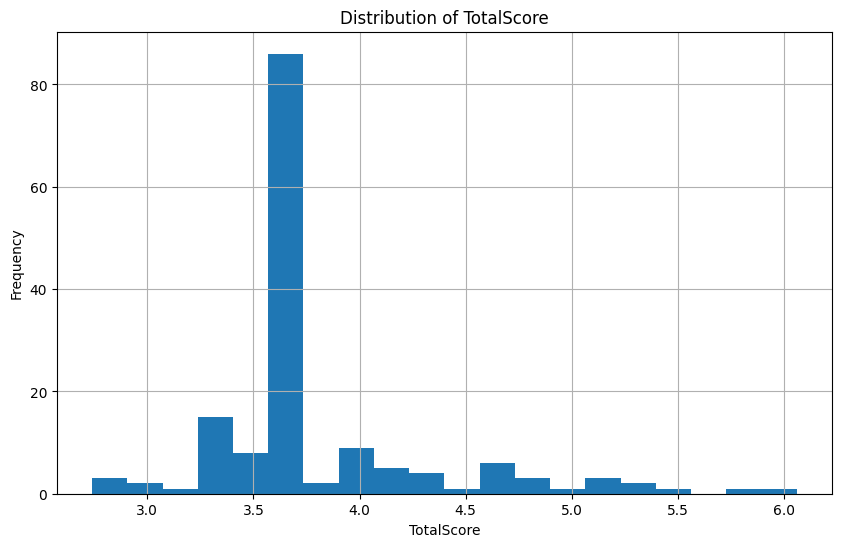

In [9]:


# Plotting the distribution of TotalScore
plt.figure(figsize=(10, 6))
result_df['TotalScore'].hist(bins=20)
plt.title('Distribution of TotalScore')
plt.xlabel('TotalScore')
plt.ylabel('Frequency')
plt.show()


In [10]:
# Calculate the threshold for the top quartile
quartile_threshold = result_df['TotalScore'].quantile(0.50)

# Filter the DataFrame to include only companies in the top quartile
top_quartile_df = result_df[result_df['TotalScore'] >= quartile_threshold]

print(top_quartile_df.shape)

print(top_quartile_df)

(85, 2)
   CompanyNumber  TotalScore
0       00403583        6.06
17      02361227        5.88
28      03877804        5.42
5       00529247        5.36
95      07191382        5.24
..           ...         ...
61      06426980        3.68
43      05931017        3.68
25      03243002        3.68
21      02700207        3.68
52      06138535        3.68

[85 rows x 2 columns]


In [11]:
lower_threshold = result_df['TotalScore'].quantile(0.25)  # 25th percentile
upper_threshold = result_df['TotalScore'].quantile(0.75)  # 75th percentile

quartile_range = (lower_threshold, upper_threshold)

quartile_range

(3.6, 3.75)

In [12]:
# Convert the DataFrame to JSON
json_data = top_quartile_df.to_json(orient='records', lines=True)

# Add commas between the JSON objects
json_data_with_commas = json_data.replace('\n', ',\n')

# Print the JSON data
print(json_data_with_commas)

{"CompanyNumber":"00403583","TotalScore":6.06},
{"CompanyNumber":"02361227","TotalScore":5.88},
{"CompanyNumber":"03877804","TotalScore":5.42},
{"CompanyNumber":"00529247","TotalScore":5.36},
{"CompanyNumber":"07191382","TotalScore":5.24},
{"CompanyNumber":"09010417","TotalScore":5.2},
{"CompanyNumber":"01726261","TotalScore":5.16},
{"CompanyNumber":"02623947","TotalScore":5.12},
{"CompanyNumber":"00987418","TotalScore":4.96},
{"CompanyNumber":"02227891","TotalScore":4.78},
{"CompanyNumber":"04234721","TotalScore":4.74},
{"CompanyNumber":"11204379","TotalScore":4.74},
{"CompanyNumber":"01563073","TotalScore":4.72},
{"CompanyNumber":"04368529","TotalScore":4.7},
{"CompanyNumber":"09771473","TotalScore":4.68},
{"CompanyNumber":"02092114","TotalScore":4.64},
{"CompanyNumber":"02388291","TotalScore":4.62},
{"CompanyNumber":"08405422","TotalScore":4.6},
{"CompanyNumber":"07304890","TotalScore":4.54},
{"CompanyNumber":"01067344","TotalScore":4.36},
{"CompanyNumber":"02981251","TotalScore":4.

In [13]:
top_quartile_df.to_csv('top_quartile_companies.csv', index=True)

In [14]:
top_quartile_df = [str(x) for x in top_quartile_df['CompanyNumber'].tolist()]

In [15]:
def get_all_filings(url, headers):
    all_filings = []
    while url:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            all_filings.extend(data.get("items", []))
            url = data.get("links", {}).get("next", None)
        else:
            print(f"Failed to fetch data, Status Code: {response.status_code}")
            print(f"Response: {response.text}")
            break
    return all_filings

def find_group_full_accounts_and_full_accounts(filings):
    account_types = ["accounts-with-accounts-type-full", "accounts-with-accounts-type-group"]
    for filing in filings:
        description = filing.get("description", "").lower()
        for account_type in account_types:
            if account_type in description:
                if "links" in filing and "document_metadata" in filing["links"]:
                    return filing["links"]["document_metadata"]
    return None

def check_if_xhtml_exists(document_metadata_url, headers):
    response = requests.get(document_metadata_url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if "application/xhtml+xml" in data.get("resources", {}):
            return True, data["resources"]["application/xhtml+xml"]["content_length"]
    return False, 0


# Base URL of the filing history API
base_url = "https://api.company-information.service.gov.uk/company"

# API key for authentication
api_key = "d45efe41-e43d-47ee-a4d0-97c0239857a2"
auth_header = base64.b64encode(f"{api_key}:".encode()).decode()

headers = {"Authorization": f"Basic {auth_header}"}

for top_quartile_df in top_quartile_df:
    url = f"{base_url}/{top_quartile_df}/filing-history"
    
    filings = get_all_filings(url, headers)
    
    if not filings:
        print(f"No filings found for company {top_quartile_df}")
        continue

    # Find group full accounts and full accounts
    document_metadata_url = find_group_full_accounts_and_full_accounts(filings)
    if document_metadata_url:
        # Check if XHTML version exists
        xhtml_exists, content_length = check_if_xhtml_exists(document_metadata_url, headers)
        if xhtml_exists:
            print(f"Company {top_quartile_df} has XHTML documents with content length {content_length}.")

Company 00403583 has XHTML documents with content length 1965931.
Company 02361227 has XHTML documents with content length 503134.
Company 03877804 has XHTML documents with content length 529897.
Company 07191382 has XHTML documents with content length 126551.
Company 09771473 has XHTML documents with content length 360972.
Company 02981251 has XHTML documents with content length 272914.
Company 04527914 has XHTML documents with content length 253929.
Company 08187280 has XHTML documents with content length 657258.
Company 02947598 has XHTML documents with content length 674043.


In [16]:
print(top_quartile_df)

06138535
